In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

/Users/guilhermemendoncafreire/mambaforge/envs/ml/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Load dataset

In [2]:
data = pd.read_csv('input_data/y/Yrep1.csv', sep=';', header=None)
Q = pd.read_csv('input_data/qmatrix/Qmatrix.csv', sep=';', header=None)
Q = Q.T
data = data.values.reshape((180, 10000)).transpose()
print(data.shape)
print(Q.shape)

(10000, 180)
(21, 180)


In [3]:
print(data)

[[0 0 1 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [0 0 1 ... 0 0 1]
 ...
 [1 1 1 ... 1 0 0]
 [1 0 1 ... 1 1 0]
 [1 1 1 ... 1 0 0]]


# Helper Functions


In [4]:
# Restrict connection in decoder
def q_constraint(w):
    target = w * Q
    diff = w - target
    w = w * tf.cast(tf.math.equal(diff, 0), keras.backend.floatx()) 
    return w * tf.cast(tf.math.greater_equal(w, 0), keras.backend.floatx())

# Remove zeros function
def remove_zeros(arr):
  n_arr = []
  
  for j in range(NUM_SKILLS): 
    for i in range(NUM_STATS):
      if Q.iloc[j, i] != 0:
        n_arr.append(arr[j][i])
  
  return n_arr


# Variables Initialization

## Training and test data 

In [5]:
tr = int(data.shape[0] * 0.8)
vl = int(data.shape[0] * 0.9)
ntest = data[tr: vl, :]
ntrain = data[:tr, :]
nval = data[vl:, :]
print(ntrain.shape)
print(ntest.shape)
print(nval.shape)

(8000, 180)
(1000, 180)
(1000, 180)


In [6]:
# Set stats and skills
NUM_STATS = 180
NUM_SKILLS = 21

AUTO = tf.data.AUTOTUNE
BUFFER_SIZE = 1024

INTERMEDIATE_DIM = 40

# Encoder and Decoder
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 1
DEC_PROJECTION_DIM = 18
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

# Optimizer
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# Number of persons
NUM_PERSONS = ntrain.shape[0]  
TRAIN_SIZE = ntrain.shape[0] 
TEST_SIZE = ntest.shape[0] 
VAL_SIZE = nval.shape[0] 

# Aparentemente para esse número de batch a acurácia binária cai para 60%.
# Quando era 5 o número de batchs era de 90%. Irei testar
BATCH_SIZE = 5 
NUM_EPOCHS = 100

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

MASK_PROPORTION = 0.50

## Load and prepare dataset

In [7]:
#train = train[..., np.newaxis]
#test = test[..., np.newaxis]
#val = val[..., np.newaxis]

train = ntrain[..., np.newaxis]
test = ntest[..., np.newaxis]
val = nval[..., np.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices(train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

## Masking layer

In [8]:
class MaskingEncoder(layers.Layer):
    def __init__(
        self,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, 1]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_stats, _) = input_shape

        # Create the projection layer for the stats.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding( 
            input_dim=self.num_stats, output_dim=self.projection_dim
        )
        #self.position_masking = layers.Masking(mask_value=-1.0)

        # Number of stats that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_stats)

    def call(self, inputs):
        # Get the positional embeddings.
        batch_size = tf.shape(inputs)[0]
        positions = tf.range(start=0, limit=self.num_stats, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_stats, projection_dim)

        ## Embed the inputs.
        input_embeddings = (
            self.projection(inputs) + pos_embeddings
        )  # (B, num_stats, projection_dim)        

        if self.downstream:
            return input_embeddings
        else:
            
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the inputs that should be unmasked.
            #input_maskings = tf.reshape(input_maskings, (18, 1))
            
            unmasked_embeddings = tf.gather(
                input_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                input_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                input_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            #TODO TENHO QUE ENTENDER AQUI***    
            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, NUM_STATS)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, inputs, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(inputs.shape[0])
        patch = inputs[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = -np.ones_like(patch)

        # Iterate of the new_patch and plug the unmasked inputs.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx


### Visualize the masking process in action on a sample person response.

Text(0.5, 1.0, 'Original')

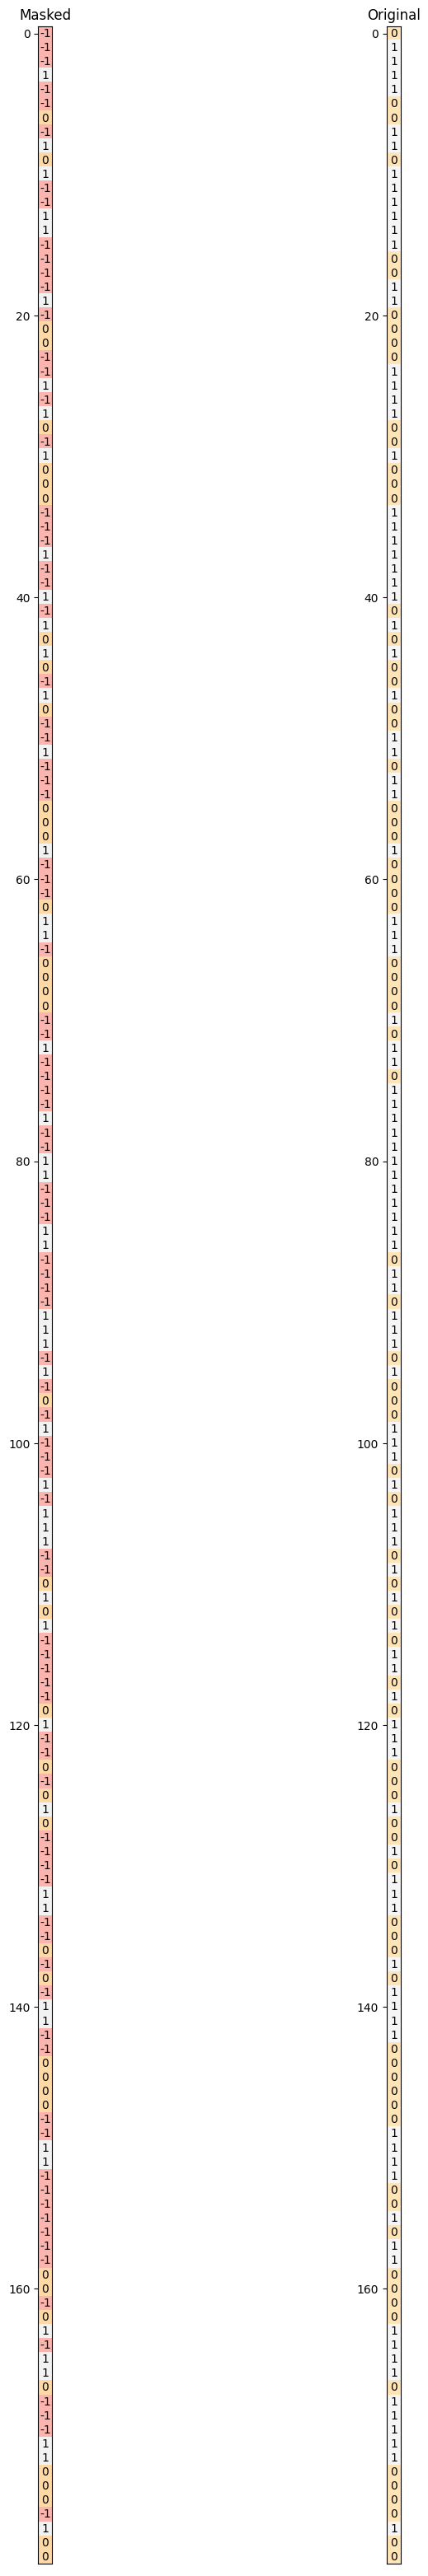

In [9]:
inputs = train


# Create the masking encoder layer.
masked_encoder = MaskingEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = masked_encoder(inputs=inputs)


# Show a maksed patch image.
new_masked, random_index = masked_encoder.generate_masked_image(inputs, unmask_indices)

fig, ax = plt.subplots(1, 2, figsize=(10, 40))

min_val, max_val = -1, 1

cmap = plt.cm.Pastel1

ax[0].matshow(new_masked, cmap=cmap)

rows = new_masked.shape[0]
cols = new_masked.shape[1]

for i in range(rows):
    for j in range(cols):
        c = new_masked[i,j]
        ax[0].text(j, i, str(c), va='center', ha='center')

ax[0].xaxis.set_visible(False)
ax[0].set_title('Masked')

cmp2 = mplt.colors.ListedColormap(['moccasin', 'whitesmoke'])

original = train[random_index].reshape(train.shape[1], 1)
ax[1].matshow(original, cmap=cmp2)

rows = original.shape[0]
cols = original.shape[1]

for i in range(rows):
    for j in range(cols):
        c = original[i,j]
        ax[1].text(j, i, str(c), va='center', ha='center')

ax[1].xaxis.set_visible(False)
ax[1].set_title('Original')

#plt.figure(figsize=(10, 10))
#plt.subplot(1, 2, 1)
#img = patch_layer.reconstruct_from_patch(new_patch)
#plt.imshow(keras.utils.array_to_img(img))
#plt.axis("off")
#plt.title("Masked")
#plt.subplot(1, 2, 2)
#img = augmented_images[random_index]
#plt.imshow(keras.utils.array_to_img(img))
#plt.axis("off")
#plt.title("Original")
#plt.show()

## MLP

This serves as the fully connected feed forward network of the transformer architecture.

In [10]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## MAE encoder

The MAE encoder is ViT. The only point to note here is that the encoder outputs a layer normalized output.## Enconder (after masking)

In [11]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

## MAE decoder

The authors point out that they use an asymmetric autoencoder model. They use a lightweight decoder that takes "<10% computation per token vs. the encoder". We are not specific with the "<10% computation" in our implementation but have used a smaller decoder (both in terms of depth and projection dimensions).



In [12]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, output_size=NUM_STATS
):
    inputs = layers.Input((NUM_STATS, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=output_size, activation="sigmoid")(x)
    outputs = layers.Reshape((output_size, 1))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


## MAE Model

In [13]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        masking_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.masking_encoder = masking_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, input):

        # Encode the inputs.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.masking_encoder(input)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_masked = decoder_outputs

        loss_patch = tf.gather(input, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_masked, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(inputs)

        # Apply gradients.
        train_vars = [
            self.masking_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        total_loss, loss_patch, loss_output = self.calculate_loss(inputs)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}


## Model initialization

In [14]:
masking_encoder = MaskingEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    masking_encoder=masking_encoder,
    encoder=encoder,
    decoder=decoder,
)


## Training callback 

### Visualization callback

In [15]:
# Taking a batch of test inputs to measure model's progress.

test_items = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.masking_encoder(test_items)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked, idx = self.model.masking_encoder.generate_masked_image(
                test_items, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original = tf.reshape(test_items[idx], (test_items.shape[1], 1)).numpy()
            #test_masked_image = self.model.patch_layer.reconstruct_from_patch(
            #    test_masked_patch
            #)
            reconstructed = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 40))
            min_val, max_val = -1, 1

            rows = original.shape[0]
            cols = original.shape[1]

            cmap = plt.cm.Pastel1
            cmp2 = mplt.colors.ListedColormap(['moccasin', 'whitesmoke'])

            ax[0].matshow(original, cmap=cmp2)
            ax[0].xaxis.set_visible(False)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].matshow(test_masked, cmap=cmap)
            ax[1].xaxis.set_visible(False)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].matshow(reconstructed, cmap=cmp2)
            ax[2].xaxis.set_visible(False)
            ax[2].set_title(f"Reconstructed: {epoch:03d}")

            for i in range(rows):
                for j in range(cols):
                    c1 = original[i,j]
                    ax[0].text(j, i, str(c1), va='center', ha='center')
                    c2 = test_masked[i,j]
                    ax[1].text(j, i, str(c2), va='center', ha='center')
                    c3 = reconstructed[i,j]
                    if c3.numpy() < 0.5:
                        c3 = 0
                    else:
                        c3 = 1
                    ax[2].text(j, i, str(c3), va='center', ha='center')

### Learning rate scheduler

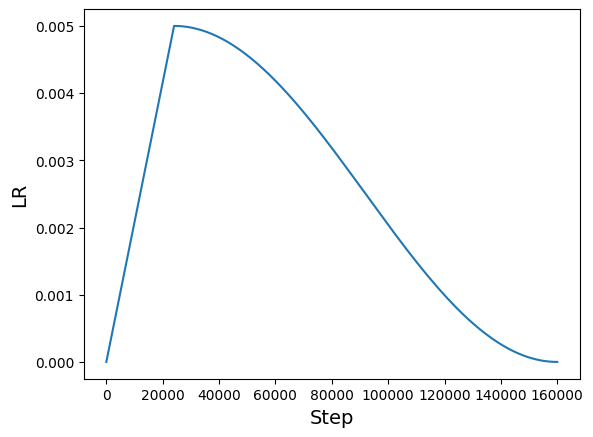

In [16]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((train.shape[0] / BATCH_SIZE) * NUM_EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=1000)]


## Model compilation and training

Epoch 1/100


2023-07-25 09:48:35.442105: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1599/1600 [============================>.] - ETA: 0s - loss: 0.2336 - binary_accuracy: 0.6170
Idx chosen: 2
1600/1600 [==============================] - 54s 28ms/step - loss: 0.2335 - binary_accuracy: 0.6170 - val_loss: 0.2258 - val_binary_accuracy: 0.6313
Epoch 2/100
1600/1600 [==============================] - 46s 29ms/step - loss: 0.2214 - binary_accuracy: 0.6407 - val_loss: 0.2207 - val_binary_accuracy: 0.6405
Epoch 3/100
1600/1600 [==============================] - 47s 29ms/step - loss: 0.2171 - binary_accuracy: 0.6489 - val_loss: 0.2166 - val_binary_accuracy: 0.6513
Epoch 4/100
1600/1600 [==============================] - 48s 30ms/step - loss: 0.2159 - binary_accuracy: 0.6516 - val_loss: 0.2144 - val_binary_accuracy: 0.6557
Epoch 5/100
1600/1600 [==============================] - 49s 31ms/step - loss: 0.2130 - binary_accuracy: 0.6583 - val_loss: 0.2138 - val_binary_accuracy: 0.6564
Epoch 6/100
1600/1600 [==============================] - 50s 32ms/step - loss: 0.2107 - binary_accu

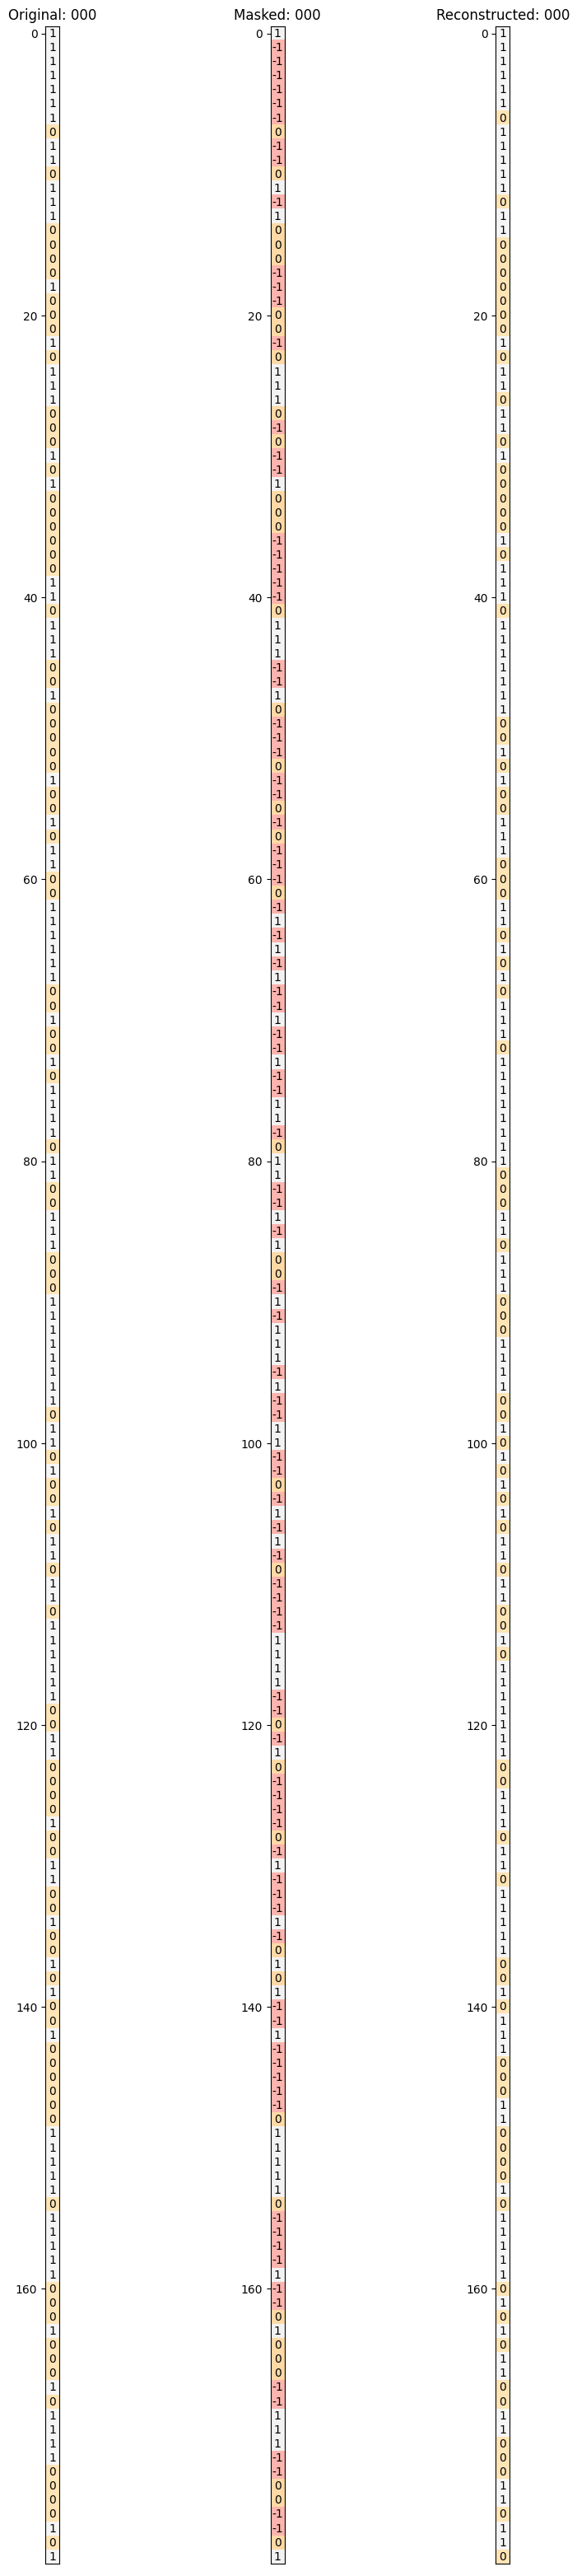

In [17]:
#optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
optimizer = keras.optimizers.experimental.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=['binary_accuracy']
)

history = mae_model.fit(
    train_ds, 
    epochs=NUM_EPOCHS,
    validation_data=val_ds, 
    callbacks=train_callbacks,
)

# Measure its performance.
loss, ba = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"Binary Accuracy: {ba:.2f}")


In [18]:
print(train.shape)

(8000, 180, 1)


# Generate masked data function

In [19]:
def generate_masked_data(inputs, unmask_indices):
    # Build a numpy array of same shape as patch.
    unmask = unmask_indices.numpy()
    new_data = -np.ones_like(inputs)

    # Iterate of the new_patch and plug the unmasked inputs.
    #for i in range(unmask_indices.shape[0]):
    #    new_patch[unmask_index[i]] = patch[unmask_index[i]]
    #eturn new_patch, idx

    for idx in range(inputs.shape[0]):
        new_data[idx][unmask[idx]] = inputs[idx][unmask[idx]]

    return new_data

# Predict for each replication

In [20]:
(
    train_unmasked_embeddings,
    train_masked_embeddings,
    train_unmasked_positions,
    train_mask_indices,
    train_unmask_indices,
) = mae_model.masking_encoder(train)
train_encoder_outputs = mae_model.encoder(train_unmasked_embeddings)
train_encoder_outputs = train_encoder_outputs + train_unmasked_positions
train_decoder_inputs = tf.concat(
    [train_encoder_outputs, train_masked_embeddings], axis=1
)
train_decoder_outputs = mae_model.decoder(train_decoder_inputs)

masked = generate_masked_data(train, train_unmask_indices)

pred = train_decoder_outputs.numpy()
pred = np.squeeze(pred, axis=2)

m = np.squeeze(masked, axis=2)

np.savetxt('output_data/50_missing/y/Y_rep1_transformer_50_missing.csv', pred, delimiter=';')
np.savetxt('output_data/50_missing/masked/Masked_rep1_50_missing.csv', m,  delimiter=';')

In [21]:
for i in range(2, 101):
    data = pd.read_csv('input_data/y/Yrep' + str(i) + '.csv', sep=';', header=None)
    data = data.values.reshape((180, 10000)).transpose()

    (
        train_unmasked_embeddings,
        train_masked_embeddings,
        train_unmasked_positions,
        train_mask_indices,
        train_unmask_indices,
    ) = mae_model.masking_encoder(train)
    train_encoder_outputs = mae_model.encoder(train_unmasked_embeddings)
    train_encoder_outputs = train_encoder_outputs + train_unmasked_positions
    train_decoder_inputs = tf.concat(
        [train_encoder_outputs, train_masked_embeddings], axis=1
    )
    train_decoder_outputs = mae_model.decoder(train_decoder_inputs)

    masked = generate_masked_data(train, train_unmask_indices)

    pred = train_decoder_outputs.numpy()
    pred = np.squeeze(pred, axis=2)

    m = np.squeeze(masked, axis=2)

    np.savetxt('output_data/50_missing/y/Y_rep' + str(i) + '_transformer_50_missing.csv', pred, delimiter=';')
    np.savetxt('output_data/50_missing/masked/Masked_rep' + str(i) + '_50_missing.csv', m,  delimiter=';')